In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns;
sns.set(style="ticks", color_codes=True)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

from pyro.infer.mcmc import MCMC, NUTS
from pyro.infer import EmpiricalMarginal
from pyro.infer.abstract_infer import TracePredictive

import numpy as np
from sklearn.datasets import make_moons, make_circles
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

torch.manual_seed(101);

# dataset

In [2]:
X, Y = make_circles(noise=0.2, factor=0.5, random_state=0, n_samples=1000)
X = scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)
batch_size = 150
full_run = True
num_iters = 10000 if full_run else 2

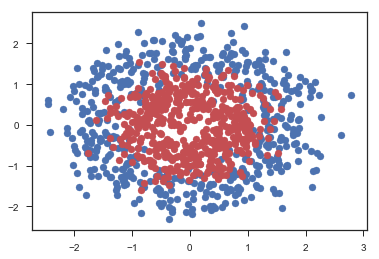

In [3]:
plt.scatter(X[Y==0, 0], X[Y==0, 1])
plt.scatter(X[Y==1, 0], X[Y==1, 1], color='r')

# Define Model

define this program precisely
  * this is regression problem, so we have:
    * a likelihood p(y|x,theta)
    * a prior over parameters p(theta)
  * takes notes
    * on the posterior predictive distribution.
    [wiki](https://en.wikipedia.org/wiki/Posterior_predictive_distribution)
  * todo: read this [paper](http://legacydirs.umiacs.umd.edu/~xyang35/files/understanding-variational-lower.pdf)

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc_1 = nn.Linear(2, 5)
        self.fc_2 = nn.Linear(5, 5)
        self.fc_3 = nn.Linear(5, 1)
    
    def forward(self, x):
        x = F.tanh(self.fc_1(x))
        x = F.tanh(self.fc_2(x))
        return F.sigmoid(self.fc_3(x))

In [5]:
model = Net()

# Define the Bayesian stuff

both the following sections need to be expiremented with. 

### Base Model

this seems to represnt the 'true' underlying distribution. need to determine:

    * what happens as the scale variables are modified?
    * figure out what the independent method call does

In [6]:
def bayesian_model(dataX, dataY):
    loc_1, scale_1 = torch.zeros(5,2), 10 * torch.ones(5,2)
    loc_bias_1, scale_bias_1 = torch.zeros(5), 10 * torch.ones(5)
    w1_prior = dist.Normal(loc_1, scale_1).independent(1)
    b1_prior = dist.Normal(loc_bias_1, scale_bias_1).independent(1)

    loc_2, scale_2 = torch.zeros(5,5), 10 * torch.ones(5,5)
    loc_bias_2, scale_bias_2 = torch.zeros(5), 10 * torch.ones(5)
    w2_prior = dist.Normal(loc_2, scale_2).independent(1)
    b2_prior = dist.Normal(loc_bias_2, scale_bias_2).independent(1)

    loc_3, scale_3 = torch.zeros(1,5), 10 * torch.ones(1,5)
    loc_bias_3, scale_bias_3 = torch.zeros(1), 10 * torch.ones(1)
    w3_prior = dist.Normal(loc_3, scale_3).independent(1)
    b3_prior = dist.Normal(loc_bias_3, scale_bias_3).independent(1)

    priors = {
        'fc_1.weight': w1_prior, 'fc_1.bias': b1_prior,
        'fc_2.weight': w2_prior, 'fc_2.bias': b2_prior,
        'fc_3.weight': w3_prior, 'fc_3.bias': b3_prior
    }

    lifted_module = pyro.random_module("module", model, priors)
    lifted_logistic_model = lifted_module()
    with pyro.iarange("map", 500, subsample_size=batch_size) as ind:
        batchX, batchY = dataX[ind], dataY[ind]
        pred = lifted_logistic_model(batchX).squeeze(-1)
        return pyro.sample('obs', dist.Bernoulli(pred), obs=batchY)

### Guide Function

this is the 'Variational' distribution. see [here](http://pyro.ai/examples/svi_part_i.html#Guide).

In [7]:
softplus = nn.Softplus()

def bayesian_model_guide(dataX, dataY):
    w1_loc = torch.randn(5, 2)
    w1_log_sig = torch.tensor(0.05 * torch.randn(5, 2))
    b1_loc = torch.randn(5)
    b1_log_sig = torch.tensor(0.05 * torch.randn(5))
    mw1_param = pyro.param("guide_mean_weight1", w1_loc)
    sw1_param = softplus(pyro.param("guide_log_scale_weight1", w1_log_sig))
    mb1_param = pyro.param("guide_mean_bias1", b1_loc)
    sb1_param = softplus(pyro.param("guide_log_scale_bias1", b1_log_sig))
    # guide distributions
    w1_dist = dist.Normal(mw1_param, sw1_param).independent(1)
    b1_dist = dist.Normal(mb1_param, sb1_param).independent(1)
    
    w2_loc = torch.randn(5, 5)
    w2_log_sig = torch.tensor(0.05 * torch.randn(5, 5))
    b2_loc = torch.randn(5)
    b2_log_sig = torch.tensor(0.05 * torch.randn(5))
    mw2_param = pyro.param("guide_mean_weight2", w2_loc)
    sw2_param = softplus(pyro.param("guide_log_scale_weight2", w2_log_sig))
    mb2_param = pyro.param("guide_mean_bias2", b2_loc)
    sb2_param = softplus(pyro.param("guide_log_scale_bias2", b2_log_sig))
    # guide distributions
    w2_dist = dist.Normal(mw2_param, sw2_param).independent(1)
    b2_dist = dist.Normal(mb2_param, sb2_param).independent(1)
    
    w3_loc = torch.randn(1, 5)
    w3_log_sig = torch.tensor(0.05 * torch.randn(1, 5))
    b3_loc = torch.randn(1)
    b3_log_sig = torch.tensor(0.05 * torch.randn(1))
    mw3_param = pyro.param("guide_mean_weight3", w3_loc)
    sw3_param = softplus(pyro.param("guide_log_scale_weight3", w3_log_sig))
    mb3_param = pyro.param("guide_mean_bias3", b3_loc)
    sb3_param = softplus(pyro.param("guide_log_scale_bias3", b3_log_sig))
    # guide distributions
    w3_dist = dist.Normal(mw3_param, sw3_param).independent(1)
    b3_dist = dist.Normal(mb3_param, sb3_param).independent(1)

    dists = {
        'fc_1.weight': w1_dist, 'fc_1.bias': b1_dist,
        'fc_2.weight': w2_dist, 'fc_2.bias': b2_dist,
        'fc_3.weight': w3_dist, 'fc_3.bias': b3_dist
    }

    lifted_module = pyro.random_module("module", model, dists)
    return lifted_module()

# Setup Optimizer

what is ELBO?
  * todo: read this [paper](http://legacydirs.umiacs.umd.edu/~xyang35/files/understanding-variational-lower.pdf)

In [8]:
optim = Adam({"lr": 0.05})
svi = SVI(bayesian_model, bayesian_model_guide, optim, loss=Trace_ELBO())

# Train

In [9]:
def main():
    pyro.clear_param_store()
    Xt, Yt = torch.Tensor(X_train), torch.Tensor(Y_train)
    for j in range(num_iters):
        # calculate the loss and take a gradient step
        loss = svi.step(Xt, Yt)
        if j % 500 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss / float(batch_size)))

In [10]:
main()

[iteration 0001] loss: 3.3192
[iteration 0501] loss: 2.2389
[iteration 1001] loss: 2.0110
[iteration 1501] loss: 1.6001
[iteration 2001] loss: 1.9318
[iteration 2501] loss: 1.4743
[iteration 3001] loss: 1.7140
[iteration 3501] loss: 1.5237
[iteration 4001] loss: 1.7237
[iteration 4501] loss: 1.5172
[iteration 5001] loss: 1.5741
[iteration 5501] loss: 1.4680
[iteration 6001] loss: 1.8018
[iteration 6501] loss: 1.7797
[iteration 7001] loss: 1.6334
[iteration 7501] loss: 1.5287
[iteration 8001] loss: 1.4832
[iteration 8501] loss: 1.9032
[iteration 9001] loss: 1.3601
[iteration 9501] loss: 1.8009


In [11]:
for name in pyro.get_param_store().get_all_param_names():
    # print("[%s]: %.3f" % (name, pyro.param(name).data.numpy()))
    print('{}:'.format(name))
    # print('{}'.format(pyro.param(name).data))

guide_mean_weight1:
guide_log_scale_weight1:
guide_mean_bias1:
guide_log_scale_bias1:
guide_mean_weight2:
guide_log_scale_weight2:
guide_mean_bias2:
guide_log_scale_bias2:
guide_mean_weight3:
guide_log_scale_weight3:
guide_mean_bias3:
guide_log_scale_bias3:


# Run Model on Test Set

In [12]:
pred_avg_20 = np.zeros(500)
for i in range(20):
    sampled_model1 = bayesian_model_guide(None, None)
    sampled_model1_pred = sampled_model1(torch.Tensor(X_test))
    sampled_model1_pred = sampled_model1_pred.data.squeeze(-1).numpy()
    pred_avg_20 = pred_avg_20 + sampled_model1_pred
pred_avg_20 = pred_avg_20 / 20.
pred_test = pred_avg_20 > 0.5
print('Accuracy (0-1 loss) = {}'.format((Y_test == pred_test).mean() * 100))

Accuracy (0-1 loss) = 86.0


# Sampling Neural Nets


the following snippet:
    1. does a discrete enumeration of R^2 around 0. (-3,+3) limit on each dimension
    2. *samples* 20 networks. each network is applied to the data generated in 1.

the sampling in (2) is with this line of code

```python
# this produces an instance of class Net!
sampled_model = bayesian_model_guide(None, None)
```

nn_samples_20 is a (20,1000) tensor containing zeros and ones. network instances correspond to rows and proedictions on that network correspond to columns.

In [13]:
grid = np.mgrid[-3:3:100j, -3:3:100j]
grid_in = grid.reshape((2,-1)).T
nn_samples = []
for i in range(20):
    sampled_model = bayesian_model_guide(None, None)
    nn_sample_pred = sampled_model(torch.Tensor(grid_in))
    nn_sample_pred = nn_sample_pred.data.squeeze(-1).numpy() # .reshape((-1,1))
    nn_samples.append(nn_sample_pred)

nn_samples_20 = np.stack(nn_samples)
print(nn_samples_20.shape)

(20, 10000)


### operations over sampled nets

this is some crazy stuff

#### mean

compute the mean over predictions of 20 nets over grid.

```python
np.mean(nn_samples_20, axis=0)
```

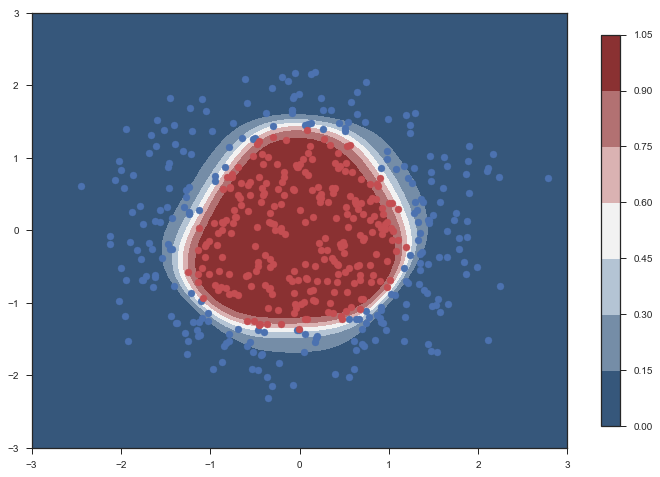

In [14]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(12,8))
contour = ax.contourf(*grid, np.mean(nn_samples_20, axis=0).reshape(100,100), cmap=cmap)
plt.scatter(X_test[pred_test == 0, 0], X_test[pred_test == 0, 1], color='b')
plt.scatter(X_test[pred_test == 1, 0], X_test[pred_test == 1, 1], color='r')
fig.colorbar(contour, ax=ax, shrink=0.9)

#### standard deviation

apparently this is one of the things you can't do with standard neural nets.

    * todo: understand/show why this is the case
    
this is cool becuase we can choose whether or not to use a prediction at a particular coordinate by requiring to be below a certain variance.

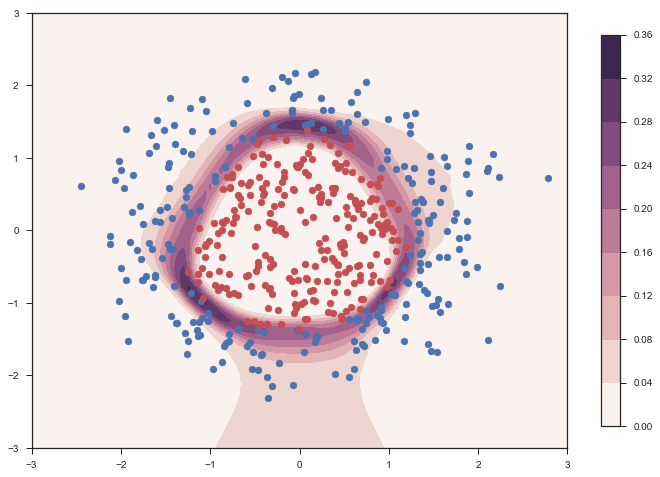

In [15]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(12,8))
contour = ax.contourf(*grid, np.std(nn_samples_20, axis=0).reshape(100,100), cmap=cmap)
plt.scatter(X_test[pred_test == 0, 0], X_test[pred_test == 0, 1], color='b')
plt.scatter(X_test[pred_test == 1, 0], X_test[pred_test == 1, 1], color='r')
fig.colorbar(contour, ax=ax, shrink=0.9)